In [2]:
!nvidia-smi

Wed Jan 19 13:39:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install fastai

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set path to root directory
path = Path('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe')
# View all files in directory
path.ls()

[PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/val'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/train'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/test'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/models'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/damage_resnet50.pkl'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/export.pkl'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/final.pkl')]

In [5]:
#data preprocessing
data = ImageDataBunch.from_folder(path, train='train', valid='val', ds_tfms=get_transforms(do_flip=False), size=224, bs=64, num_workers=8)

In [6]:
# Show what the data looks like after being transformed
data.show_batch()

Output hidden; open in https://colab.research.google.com to view.

In [6]:
# See the classes and count of classes in your dataset
print(data.classes,data.c)


['minor', 'moderate', 'severe'] 3


In [7]:
# See the number of images in each data set
print(len(data.train_ds), len(data.valid_ds))

919 114


In [8]:
# Build the CNN model with the pretrained resnet34
# Error rate = 1 - accuracy
learn = cnn_learner(data, models.resnet50, metrics = [accuracy , FBeta(), Precision(), Recall()])
# Train the model on 4 epochs of data at the default learning rate
learn.fit_one_cycle(6)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,1.666381,1.375231,0.631579,0.605957,0.615865,0.622979,00:36
1,1.469170,1.609268,0.657895,0.648448,0.645534,0.649180,00:08
2,1.253040,1.390308,0.649123,0.641079,0.628889,0.644200,00:08
3,1.042916,1.091755,0.622807,0.607448,0.597673,0.609941,00:08
4,0.886095,1.149294,0.596491,0.581417,0.558903,0.587331,00:08
5,0.779511,1.127587,0.605263,0.591046,0.570779,0.596340,00:08


In [10]:
# Save the model
learn.save('stage-1')
# Load the Model
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (919 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
moderate,moderate,moderate,moderate,moderate
Path: /content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe;

Valid: LabelList (114 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
minor,minor,minor,minor,minor
Path: /content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 4.79E-05


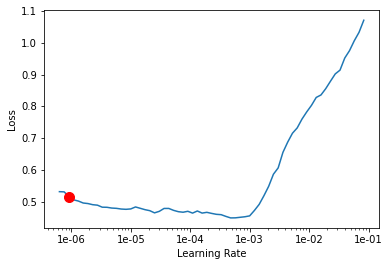

In [9]:
#finding optimum learning rate
# Unfreeze all layers of the CNN
learn.unfreeze()
# Find the optimal learning rate and plot a visual
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [10]:
# Fit the model over 2 epochs
learn.fit_one_cycle(4, max_lr=slice(3e-7, 3e-6))

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,0.521539,1.130157,0.596491,0.576023,0.562222,0.585923,00:09
1,0.520721,1.124788,0.587719,0.571171,0.549297,0.576914,00:09
2,0.538265,1.131120,0.605263,0.590773,0.574701,0.594932,00:08
3,0.507748,1.132478,0.596491,0.581417,0.558903,0.587331,00:09


In [11]:
# Fit the model over 2 epochs
learn.fit_one_cycle(10, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,0.433089,1.043800,0.631579,0.611326,0.606335,0.615941,00:08
1,0.384097,1.149202,0.640351,0.628846,0.648470,0.624124,00:09
2,0.372357,2.068316,0.649123,0.623711,0.626024,0.623136,00:09
3,0.354449,1.602108,0.578947,0.599338,0.651820,0.587512,00:09
4,0.347451,1.620921,0.640351,0.627318,0.624002,0.628153,00:08
5,0.308637,1.782627,0.605263,0.583455,0.601724,0.579060,00:09
6,0.257885,1.283964,0.701754,0.696688,0.700151,0.695827,00:08
7,0.216970,1.322117,0.701754,0.695698,0.701653,0.694225,00:08
8,0.175403,1.336920,0.692982,0.685913,0.688711,0.685216,00:09
9,0.145036,1.338056,0.701754,0.691753,0.700439,0.689615,00:08


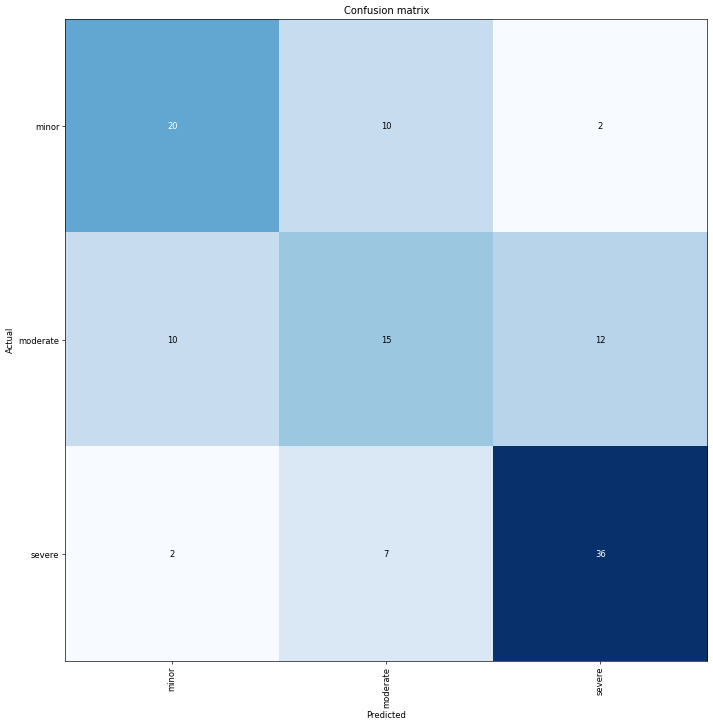

In [24]:
# Rebuild interpreter and replot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
#text version of cm
interp.most_confused(min_val=2)

[('minor', 'moderate', 10),
 ('moderate', 'severe', 10),
 ('severe', 'moderate', 6),
 ('moderate', 'minor', 5),
 ('minor', 'severe', 3),
 ('severe', 'minor', 3)]

In [20]:
# Save the model
learn.save('stage-2')

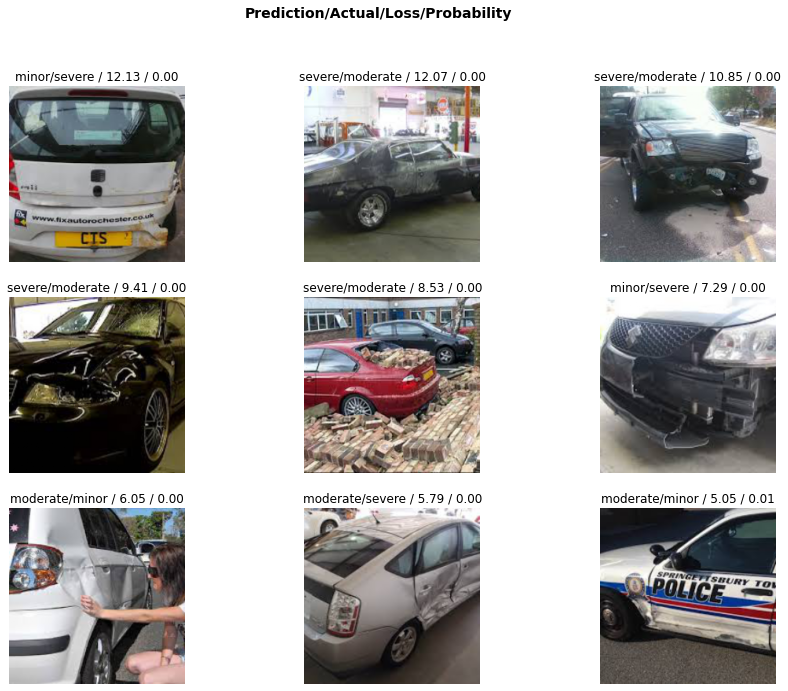

In [31]:
# Show top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))

In [12]:
#exporting the file
learn.export()

In [42]:
learn_pl = load_learner(path, 'final.pkl')

In [28]:
path.ls()

[PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/val'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/train'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/test'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/models'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/damage_resnet50.pkl'),
 PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/export.pkl')]

In [29]:
path

PosixPath('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe')

In [21]:
path = Path('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe')
data = ImageDataBunch.from_folder(path, train='train', valid='val', ds_tfms=get_transforms(do_flip=False), size=224, bs=64, num_workers=8)
learn2 = cnn_learner(data, models.resnet50, metrics = [accuracy , FBeta(), Precision(), Recall()])
learn2.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (919 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
moderate,moderate,moderate,moderate,moderate
Path: /content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe;

Valid: LabelList (114 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
minor,minor,minor,minor,minor
Path: /content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), s

In [22]:
learn2.predict(path,'test/moderate/0056.JPEG')

AttributeError: ignored

In [24]:
from PIL import Image as PImage
from fastai.vision import *
import cv2
pil_img = PIL.Image.open('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/test/minor/0034.JPEG')
img = np.asarray(pil_img)
preds_num = learn2.predict(img)

AttributeError: ignored

In [37]:
pil_img = PIL.Image.open("/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/test/moderate/0181.JPEG")
img = np.asarray(pil_img) # Image to display

In [ ]:
img.shape

In [30]:
#import torch
from fastai.vision import Path,load_learner,Image

learn = load_learner(path , 'export.pkl')

In [14]:
import PIL.Image
import numpy as np

In [15]:
pil_img = PIL.Image.open('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/test/minor/0034.JPEG')

In [16]:
img = np.asarray(pil_img)

In [33]:

p = cv2.imread('/content/drive/MyDrive/damage_assess_sahaj/minor_moderate_severe/test/moderate/0105.JPEG') # p is numpy array with shape (height,width,channels)
t = pil2tensor(p, dtype=np.uint8) # converts to numpy tensor
#t = t.permute(2,0,1) # Move num_channels as first dimension
t = t.float()/255. #Convert to float
im = Image(t) # Convert to fastAi Image - this class has "apply_tfms"
learn.predict(im)

(Category tensor(1), tensor(1), tensor([2.3425e-04, 9.9672e-01, 3.0470e-03]))

In [6]:
#offline data augmentation
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import numpy as np
import os
from PIL import Image

In [28]:
import albumentations as A
import cv2
import glob

image_dir = "/content/drive/MyDrive/damage_assess_sahaj/car_damaged/train/damage"
# Declare an augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=(-20,20), p=0.5),
    A.HorizontalFlip(p=0.5)
])

image_list = glob.glob(image_dir + "/*")

for img in image_list:

  # Read an image with OpenCV and convert it to the RGB colorspace
  image = cv2.imread(img)
  image_name = img.split("/")[-1].replace(".JPEG" , "_aug.JPEG")
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Augment an image
  transformed = transform(image=image)
  transformed_image = transformed["image"]
  cv2.imwrite(os.path.join("/content/drive/MyDrive/damage_assess_sahaj/car_damaged/train/damage_augmented",image_name ) , transformed_image)